# AR(1) exercise - bias and overfitting

> Joris de Wind (1:1 Analytics, DBNL)

In this exercise you will discover that the autoregressive coefficient of a persistent AR(1) model is biased downwards. The reason is because the standard estimation procedure takes the first observation as given, and simply ignores the likelihood of this observation. The maximum likelihood or OLS procedure will take advantage of this, which leads to overfitting and a downward bias. You will need to study some simulations to build intuition why this is the case!

Along the way, you will need to write functions to calculate the unconditional mean and standard deviation of an AR(1) process. Of course, you will also need to program a function to run a simulation, and last but not least you will need to run a Monte Carlo exercise to study the bias of the autoregressive coefficient!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as st

from math import sqrt
from numba import jit  # see numba.pydata.org for the documentation on
                       # Numba, which is an open source JIT compiler that
                       # translates a subset of Python and NumPy code into
                       # fast machine code

## Unconditional mean and standard deviation

Consider the AR(1) model:

> $y_t = \mu + \varrho y_{t-1} + \varepsilon_t$
with $\varepsilon_t \sim N(0, \sigma^2)$

Let's define the __unconditional mean__ of $y_t$ as $E y_t = E y_{t-1} = \mu_{y}$.$^1$ To calculate the unconditional mean, you need to take expectations on both sides of the AR(1) equation and solve for $\mu_{y}$. In exercise 1.1 you will need to perform the algebra, and add the solution to the AR(1) class definition below.

Similarly, let's define the __unconditional standard deviation__ of $y_t$ as $\sqrt{ E(y_t - \mu_{y})^2 } = \sqrt { E(y_{t-1} - \mu_{y})^2 } = \sigma_y$. To calculate the unconditional standard deviation, you need to perform similar algebraic manipulations as for the unconditional mean, though it's a bit more tedious now. In particular, first subtract $\mu_{y}$ from both sides of the AR(1) equation, then square both sides and take expectations, and finally solve for $\sigma_y$. This is what you have to do in exercise 1.2!

$^1$If you are unfamiliar with the concept of the unconditional distribution, first note that the conditional mean or expectation of the AR(1) process is simply $E_{t-1} y_t = \mu + \varrho y_{t-1}$, i.e. we use the information that we have at time _t-1_ to the best of our knowledge. However, in the case of the unconditional distribution we simply don't have such information, and this distribution has therefore a larger variance. Finally, note that if we make a forecast for many steps ahead the forecast distribution will converge to the unconditional distribution, as the current information set becomes less and less useful the further we look into the future.

## Exercise 1

I already defined an AR(1) class but you will need to complete the components related to the unconditional distribution:

1. Derive the formula for the unconditional mean & complete the method *calculate_unconditional_mean()*
2. Derive the formula for the unconditional standard deviation & complete the method *calculate_unconditional_std()*
3. Note that these methods are used to calculate the 95% confidence interval, make sure you understand this!

In [2]:
class AR1:

    # constructor and properties
    # ==========================

    # note that this class makes use of properties and a custom printing method
    # if you are unfamiliar with this, it's just a way to set private attributes,
    # and for the sake of this exercise you can simply ignore the first part of
    # the code

    def __init__(self, mu, rho, sigma, suppress_stationarity_warning=False):
        self.suppress_stationarity_warning = suppress_stationarity_warning
        self.mu = mu
        self.rho = rho
        self.sigma = sigma

    # mu
    @property
    def mu(self):
        return self.__mu

    @mu.setter
    def mu(self, mu):
        self.__mu = mu

    # rho
    @property
    def rho(self):
        return self.__rho

    @rho.setter
    def rho(self, rho):
        if abs(rho) >= 1 and not self.suppress_stationarity_warning:
            print("Warning: the AR(1) process with \u03C1 = {} ".format(rho) + \
            "is non-stationary!\nProceed on your own risk!\n\n")
        self.__rho = rho

    # sigma
    @property
    def sigma(self):
        return self.__sigma

    @sigma.setter
    def sigma(self, sigma):
        self.__sigma = sigma

    # printing
    def __str__(self):
        str = \
            "The AR(1) model has the following parameter configuration:" + \
            "\n\t" + \
            "y(t) = {} + {} y(t-1) + u(t)".format(
                self.mu, self.rho, self.sigma) + \
            "\n\t" + \
            "u(t) ~ N(0, {}^2)".format(self.sigma) + \
            "\n\n" + \
            "The unconditional distribution of the AR(1) process is:" + \
            "\n\t" + \
            "y(t) ~ N({}, {}^2)".format(
                round(self.calculate_unconditional_mean(), 1),
                round(self.calculate_unconditional_std(), 4)) + \
            "\n\n"
        return str

    # unconditional distribution <= exercise 1
    # ==========================

    def calculate_unconditional_mean(self):  # <= this method should be completed in exercise 1.1
        if abs(self.rho) >= 1:
            return float('Inf')
        return self.mu / (1 - self.rho)

    def calculate_unconditional_std(self):  # <= this method should be completed in exercise 1.2
        if abs(self.rho) >= 1:
            return float('Inf')
        return self.sigma / sqrt(1 - self.rho**2)

    def calculate_confidence_interval(self, alpha=0.95):
        if abs(self.rho) >= 1:
            return (float('Inf'), float('Inf'))
        al = (1 - alpha) / 2
        ah = 1 - al
        unconditional_mean = self.calculate_unconditional_mean()
        unconditional_std = self.calculate_unconditional_std()
        lower = st.norm.ppf(al, unconditional_mean, unconditional_std)
        upper = st.norm.ppf(ah, unconditional_mean, unconditional_std)
        return (lower, upper)

    # simulate data <= exercise 2
    # =============

    @jit
    def simulate(self, nr_of_periods=200, nr_of_simulations=1):  # <= this method should be completed in exercise 2.1
        if abs(self.rho) >= 1:
            print("Simulation of a non-starionary process is not supported!")
            return
        y = np.empty((nr_of_periods+1, nr_of_simulations))
        y[0, ] = self.calculate_unconditional_mean() + \
                 self.calculate_unconditional_std() * \
                 np.random.randn(1, nr_of_simulations)
        u = self.sigma * np.random.randn(nr_of_periods, nr_of_simulations)
        for t in range(nr_of_periods):
            y[t+1, ] = self.mu + self.rho * y[t, ] + u[t, ]
        return y

    # estimate AR(1) using OLS
    # ========================

    # note that the method below is a static method, so it should be called by
    # AR1.estimate_ar1(y), where y should be an array with the data
    # furthermore, the method returns an AR1 object with the estimated parameters

    @staticmethod
    def estimate_ar1(y):
        X = y[:-1]
        X = sm.add_constant(X)
        y = y[1:]
        ar1_hat = sm.OLS(y, X).fit()
        mu_hat, rho_hat = ar1_hat.params
        sigma_hat = sqrt(ar1_hat.mse_resid)
        return AR1(mu_hat, rho_hat, sigma_hat, True)

## Exercise 2

1. Of course, a class for a time series model is not complete without a method to simulate random data. So, hurry back to the above class and complete the simulation method!
2. After that you can play around with the AR(1) class. Make sure to understand the various components before moving to the Monte Carlo exercise.

In [3]:
# playing around with the AR1 class
ar1 = AR1(0.1, 0.9, 0.007)
print(ar1)

ar1.rho = 2
print(ar1)

ar1.rho = 0.9
ys = ar1.simulate(nr_of_periods=50, nr_of_simulations=1_000)
print("The shape of ys is {} by {}\n\n".format(*ys.shape))

The AR(1) model has the following parameter configuration:
	y(t) = 0.1 + 0.9 y(t-1) + u(t)
	u(t) ~ N(0, 0.007^2)

The unconditional distribution of the AR(1) process is:
	y(t) ~ N(1.0, 0.0161^2)


Proceed on your own risk!


The AR(1) model has the following parameter configuration:
	y(t) = 0.1 + 2 y(t-1) + u(t)
	u(t) ~ N(0, 0.007^2)

The unconditional distribution of the AR(1) process is:
	y(t) ~ N(inf, inf^2)


The shape of ys is 51 by 1000




## Monte Carlo exercise - part 1

1. Run a Monte Carlo simulation to count how often the first observation falls outside the 95% confidence interval. You basically need to complete the for loop.
2. Normally, how often should an observation fall outside its the 95% confidence interval?
3. Can you explain the discrepancy? Don't worry if you can't explain it yet, you will build the intuition in the remainder of this exercise!

In [4]:
# Monte Carlo exercise
T = 50
M = 10_000
rho = 0.95
ar1 = AR1(0, rho, 0.01)
np.random.seed(973)
ys = ar1.simulate(nr_of_periods=T, nr_of_simulations=M)
rs = np.zeros(M)
count = 0
for i in range(M):
    y = ys[:, i]
    ar1_hat = AR1.estimate_ar1(y)
    rs[i] = ar1_hat.rho
    (lower, upper) = ar1_hat.calculate_confidence_interval()
    if y[0] < lower or y[0] > upper:
        count += 1

print("The percentage of Monte Carlo samples in which the first observation" + \
" falls\noutside the 95% confidence interval is:\n\t{}%\n\n".format(
    round(100 * count / M, 2)))

The percentage of Monte Carlo samples in which the first observation falls
outside the 95% confidence interval is:
	26.96%




## Monte Carlo exercise - part 2

1. Go back to the for loop of your Monte Carlo simulation, and save the estimated autoregressive coefficients in the vector rs.
2. After that you can plot a histogram of the estimated autoregressive coefficients versus the true value.
3. Can you explain the result?

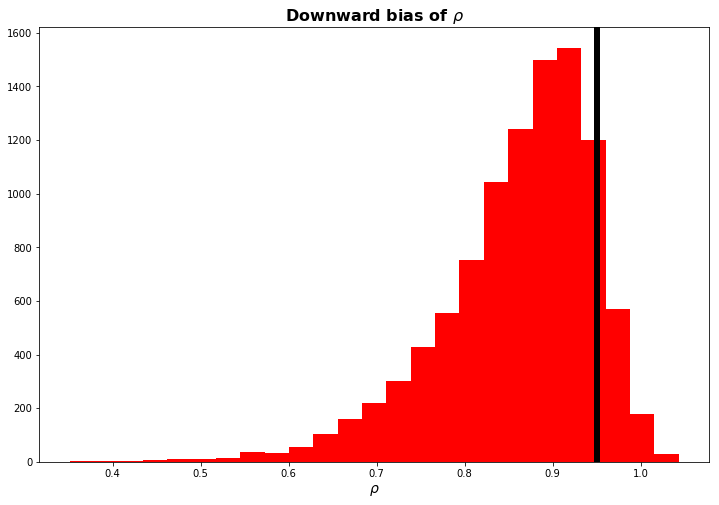

In [5]:
plt.figure(figsize=(12, 8))
plt.hist(rs, bins=25, color='r')
plt.axvline(x=rho, color='k', linewidth=6)
plt.title(r"Downward bias of $\rho$", fontsize=16, fontweight='bold')
plt.xlabel(r"$\rho$", fontsize=14)
plt.show()
print("\n\n")

## Monte Carlo exercise - part 3

In this exercise you don't need any programming, but you are challenged to build the intuition for the plot you can generate with the code below.

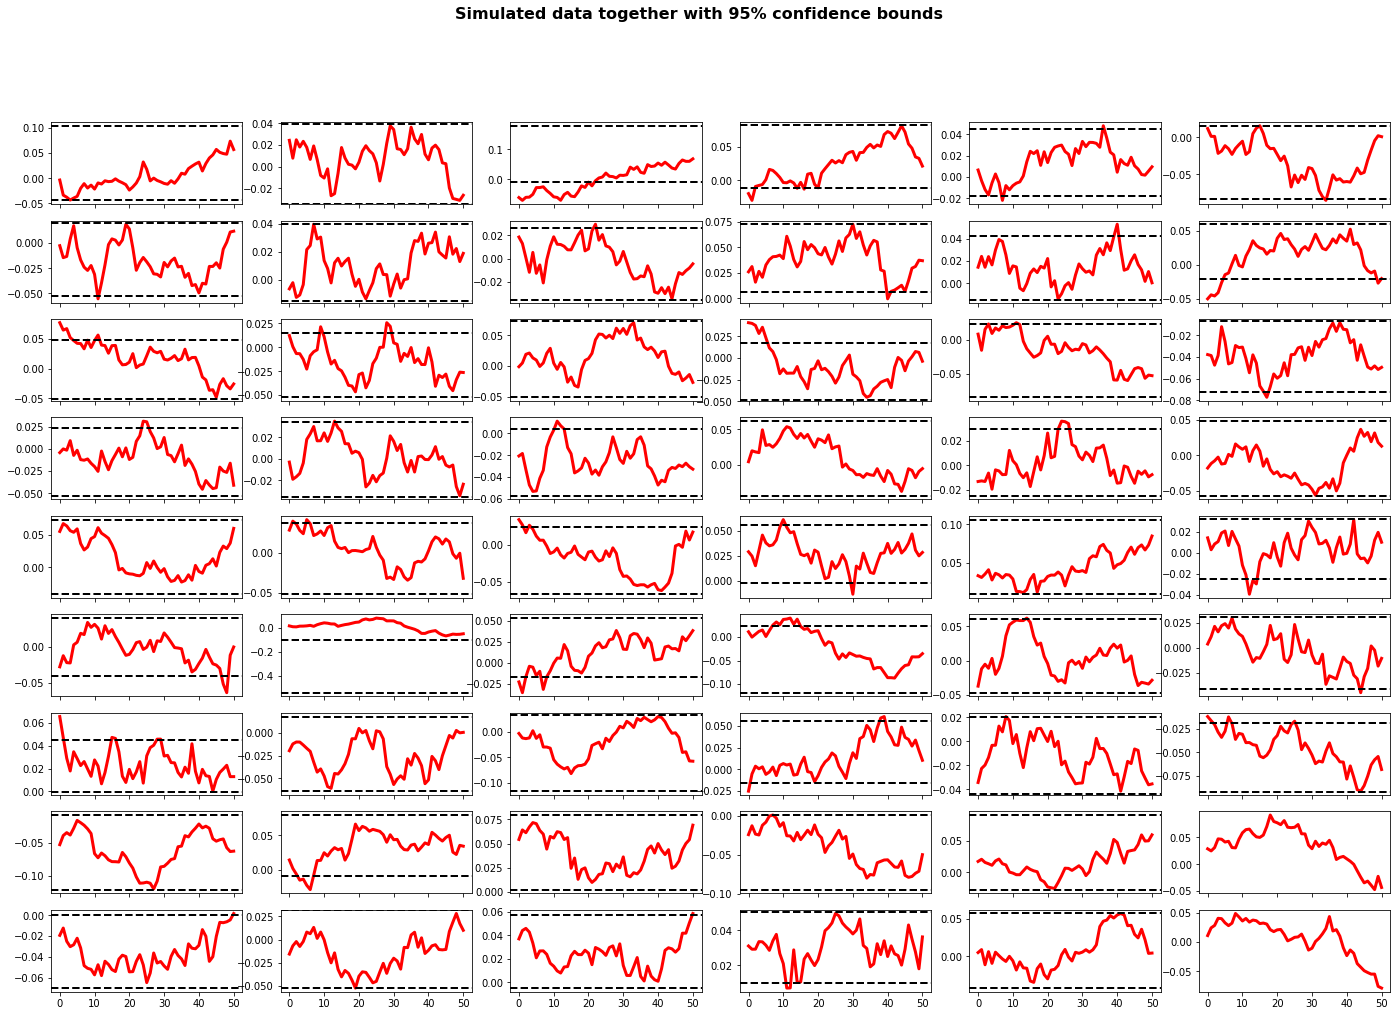

In [6]:
ncols, nrows = 9, 6
fig, axs = plt.subplots(ncols, nrows, sharex=True, sharey=False,
                        figsize=(24, 16))
for i in range(ncols):
    for j in range(nrows):
        y = ys[:, i * ncols + j]
        (lower, upper) = AR1.estimate_ar1(y).calculate_confidence_interval()
        axs[i, j].plot(y, color='red', linewidth=3)
        axs[i, j].axhline(lower, linestyle='--', color='k', linewidth=2)
        axs[i, j].axhline(upper, linestyle='--', color='k', linewidth=2)
fig.suptitle("Simulated data together with 95% confidence bounds",
             fontsize=16, fontweight='bold')
plt.show()

## Wrap-up

The downward bias and overfitting problem becomes worse with

- more persistent data
- shorter samples
- in multivariate settings

#### For the techies

If we forget to include the first observation in the likelihood function, it makes sense that things can go wrong, right? But how does this relate to the well-known OLS bias result for AR(1) processes:

$\hat{\varrho} = \varrho + E \left[ \frac{\Sigma_{t=2}^{T} y_{t-1} \varepsilon_t}{\Sigma_{t=2}^{T} y_{t-1}^2 } \right]$

where it's commonly said that the second term on the right-hand side is non-zero, and thus that the OLS estimate is biased.

However, if we condition on the first observation we basically assume that the first observation has a flat prior, and then the denominator will go to infinity and the bias actually disappears under these assumptions.

Note that the problem itself doesn't disappear, but it's just not a bias problem. Instead the problem is the conditioning on the first observation which implies a flat prior that is unrealistic in most situations.